In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/alzhiemers_pro/

/content/drive/MyDrive/alzhiemers_pro


In [ ]:
# !pwd

In [ ]:
# !unzip archive\(1\).zip

In [ ]:
!pip3 install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.14.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
base_dir = "Alzheimer_Dataset_final/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
WORK_DIR = 'dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176,176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


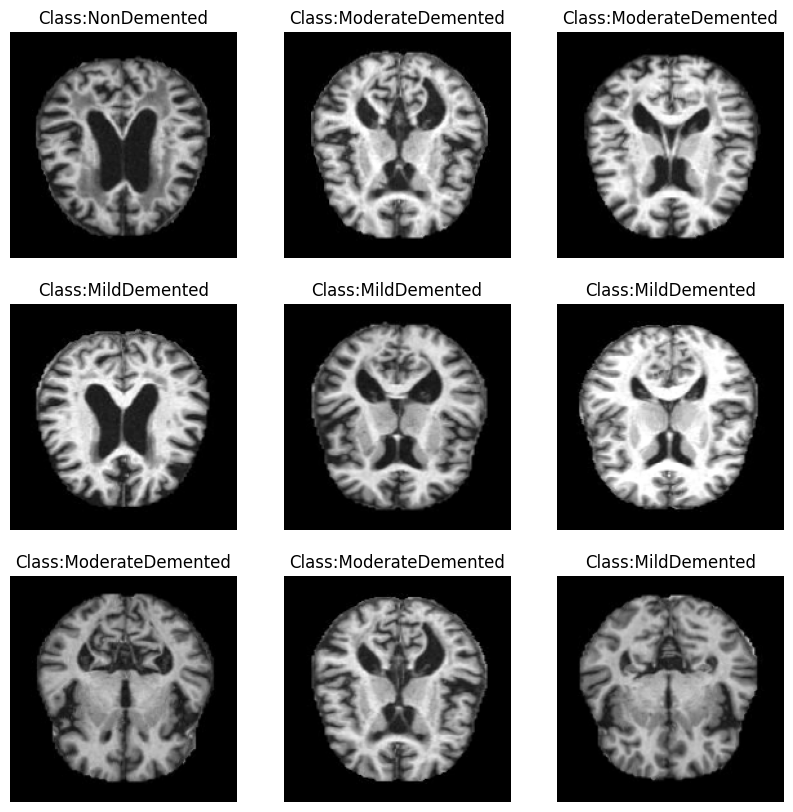

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """

    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))

    # get a batch of images
    x,y = generator.next()

    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

# Display Train Images
show_images(train_data_gen)

In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced

# sm = SMOTE(random_state=42)

# train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

In [ ]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=10)

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]

custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
  6/128 [>.............................] - ETA: 9s - loss: 1.9355 - acc: 0.2500 - auc: 0.5061 - f1_score: 0.2058 

128/128 [==============================] - 34s 92ms/step - loss: 1.5170 - acc: 0.3706 - auc: 0.6355 - f1_score: 0.2631 - val_loss: 1.0057 - val_acc: 0.5527 - val_auc: 0.8238 - val_f1_score: 0.2891 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 9s 69ms/step - loss: 1.1528 - acc: 0.4951 - auc: 0.7688 - f1_score: 0.3062 - val_loss: 0.9627 - val_acc: 0.5498 - val_auc: 0.8320 - val_f1_score: 0.2825 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 10s 75ms/step - loss: 1.0188 - acc: 0.5308 - auc: 0.8118 - f1_score: 0.3219 - val_loss: 0.9266 - val_acc: 0.5586 - val_auc: 0.8388 - val_f1_score: 0.2924 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 10s 77ms/step - loss: 0.9593 - acc: 0.5513 - auc: 0.8302 - f1_score: 0.3328 - val_loss: 0.8976 - val_acc: 0.5703 - val_auc: 0.8494 - val_f1_score: 0.3071 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 9s 70ms/step - loss: 0.9172 - acc: 0.5801 - auc: 0.8449 - f1_score: 0.

In [ ]:

test_scores = custom_inception_model.evaluate(test_data, test_labels)

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 2s 51ms/step - loss: 0.6465 - acc: 0.7672 - auc: 0.9401 - f1_score: 0.6711
Testing Accuracy: 76.72%


In [ ]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

40/40 [==============================] - 3s 48ms/step


In [ ]:
#Saving the model for future use

custom_inception_model_dir = work_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(work_dir)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented',
 'alzheimer_inception_cnn_model']

In [ ]:
prediction = custom_inception_model.predict(train_data)

print(prediction)



128/128 [==============================] - 6s 49ms/step
[[9.28746581e-01 4.23360558e-04 2.38333251e-02 4.69967052e-02]
 [4.88624815e-03 1.27597605e-05 1.01249581e-02 9.84975994e-01]
 [9.96851504e-01 2.35349603e-06 2.65629380e-04 2.88046058e-03]
 ...
 [6.76319329e-03 2.18645673e-05 9.32392292e-03 9.83891070e-01]
 [4.72500082e-03 3.97380558e-04 9.82639551e-01 1.22380424e-02]
 [9.73264873e-01 1.62415818e-04 8.92962515e-03 1.76430643e-02]]


In [ ]:
print(test_data[1].shape)

(176, 176, 3)


In [ ]:
predict = test_data[1].reshape(-1, IMG_SIZE, IMG_SIZE, 3)
pred = custom_inception_model.predict(predict)
print(pred.argmax())
print(pred)

1/1 [==============================] - 2s 2s/step
2
[[1.5519660e-04 1.6951468e-05 9.9800390e-01 1.8239202e-03]]


In [ ]:
test_labels[1].argmax()

2

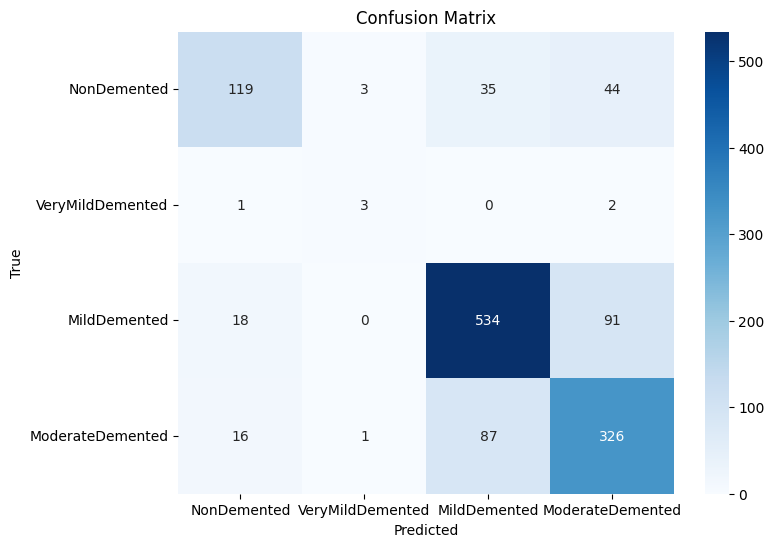

Classification Report:
                   precision    recall  f1-score   support

     NonDemented       0.77      0.59      0.67       201
VeryMildDemented       0.43      0.50      0.46         6
    MildDemented       0.81      0.83      0.82       643
ModerateDemented       0.70      0.76      0.73       430

        accuracy                           0.77      1280
       macro avg       0.68      0.67      0.67      1280
    weighted avg       0.77      0.77      0.77      1280



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you have predictions and true labels
# Replace these with your actual predictions and true labels
predicted_classes = np.argmax(pred_labels, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
class_report = classification_report(true_classes, predicted_classes, target_names=CLASSES)
print("Classification Report:\n", class_report)


In [ ]:
from sklearn.metrics import matthews_corrcoef

# Assuming you have predictions and true labels
# Replace these with your actual predictions and true labels
predicted_classes = np.argmax(pred_labels, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(true_classes, predicted_classes)

print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.6144922197179127


In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Assuming you have predictions and true labels
# Replace these with your actual predictions and true labels
predicted_classes = np.argmax(pred_labels, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Calculate Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(true_classes, predicted_classes)

print("Balanced Accuracy Score:", balanced_acc)


Balanced Accuracy Score: 0.6701653627410705
